In [1]:
from skimage.io import imread, imshow, show, imsave
from skimage.filters import sobel
from skimage.feature import canny
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from PIL import Image
import os
from scipy.signal import convolve2d
import math
%matplotlib inline
import imutils

import warnings
warnings.filterwarnings('ignore')

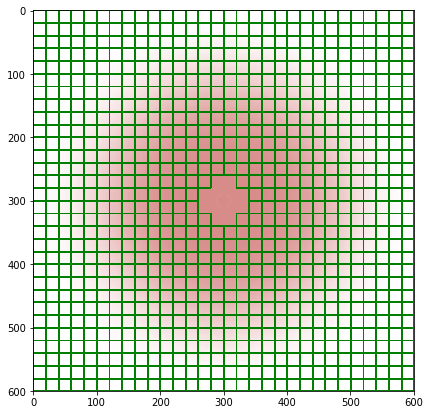

In [2]:
def split_tiles(img, l):

    w, h = img.size
    stride_x = round(w // l)
    stride_y = round(h // l)

    splited_image = []
    for i in range(0, w, stride_x):
        for j in range(0, h, stride_y):
            cropped = img.crop((i, j, i+stride_x, j+stride_y))
            cropped = np.asarray(cropped.convert('L'))
            splited_image.append((((i, j), (i+stride_x, j+stride_y)), cropped))
    return splited_image


def tenengrad(img):

    Sx = [
        [-1, 0, 1], 
        [-2, 0, 2], 
        [-1, 0, 1]
    ]
    
    Sy = [
        [1, 2, 1], 
        [0, 0, 0], 
        [-1, -2, -1]
    ]

    Gx = convolve2d(img, Sx)
    Gy = convolve2d(img, Sy)
    
    S = np.sqrt(np.square(Gx) + np.square(Gy))
    thr = np.max(S) * 4/5
    res = S[S > thr]
    res = np.sum(np.square(res))
    return res

def grid_tenengrad(file_path, l, bound=1/3):
    
    init_image = cv2.imread(file_path)
    img = Image.open(file_path)

    splitted = split_tiles(img, l)
    teng_values, blurred_areas = [], []
    
    for tile in splitted:
        teng_value = tenengrad(tile[1])
        blurred_areas.append((tile[0], teng_value))
        teng_values.append(teng_value)
    threshold = max(teng_values) * bound

    for tile in blurred_areas:
        if tile[1] > threshold:
            (x1, y1), (x2, y2) = tile[0][0], tile[0][1]
            cv2.rectangle(init_image, (x1, y1), (x2, y2), (0, 127, 0), 2)
    tenengrad_image = init_image
    cv2.imwrite('tenengrad_res.png', tenengrad_image)
    return tenengrad_image


def apply_tenengrad(file_path='blur.jpg'):
    l = 30
    tenengrad_image = grid_tenengrad(file_path, l)
    plt.figure(figsize=(9, 7))
    plt.imshow(tenengrad_image)


apply_tenengrad()

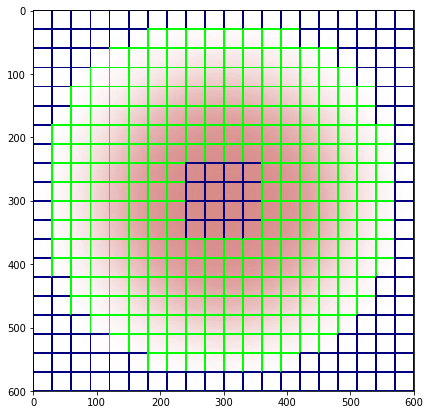

In [3]:
def glvn(img):
    
    mean, stdev = cv2.meanStdDev(img)
    s = stdev[0]**2 / mean[0]
    return s[0]


def grid_glvn(filename, l):
    init = cv2.imread(filename)
    img = Image.open(filename)
    splitted = split_tiles(img, l)
    
    glvn_values, blurred_areas = [], []
    for tile in splitted:
        glvn_curr = glvn(tile[1])
        blurred_areas.append((tile[0], glvn_curr))
        glvn_values.append(glvn_curr)
    
    threshold = max(glvn_values) * 0.05
    
    for tile in blurred_areas:
        if tile[1] < threshold:
            (x1, y1), (x2, y2) = tile[0][0], tile[0][1]
            cv2.rectangle(init, (x1, y1), (x2, y2), (0, 0, 127), 2)
        else:
            (x1, y1), (x2, y2) = tile[0][0], tile[0][1]
            cv2.rectangle(init, (x1, y1), (x2, y2), (0, 255, 0), 2)
    glvn_image = init
    return glvn_image
        

def apply_glvn(filename='blur.jpg'):

    l = 20
    glvn_image = grid_glvn(filename, l)
    plt.figure(figsize=(9, 7))
    plt.imshow(glvn_image)


apply_glvn()

# Фильтр Собеля с порогом 0.05

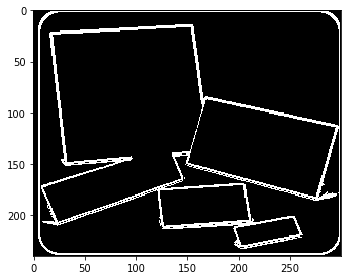

In [4]:
image = cv2.imread('squares.jpg', 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sobel_img = sobel(gray)
binary = sobel_img > 0.05
imshow(binary)
show()

# Аппроксимация границ с помощью OpenCV

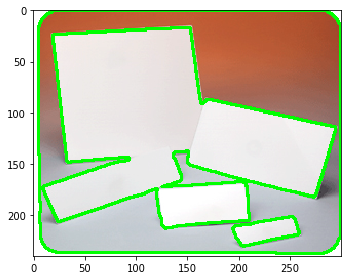

In [5]:
canvas = np.zeros(image.shape, np.uint8)
# img2gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel = np.ones((5,5),np.float32)/25
gray = cv2.filter2D(gray,-1,kernel)

ret,thresh = cv2.threshold(gray,215,255,cv2.THRESH_BINARY_INV)
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

imshow(cv2.drawContours(image, contours, -1, (0,255,0), 2))
show()

Вручную проходим по контуру и находим прямые углы

In [6]:
image = cv2.imread('squares.jpg', 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def angle(x1, x2, y1, y2):
    r = (math.atan2(y2, x2) - math.atan2(y1, x1)) * (180.0 / math.pi)
    if r < 0:
        r += 360.0
    return r


def point_to_vect(x1, x2, y1, y2):
    return x2-x1, y2-y1


class Contour:
    def __init__(self, cnt):
        self.cnt = cnt
        self.area = cv2.contourArea(cnt)
        self.approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)

    def angles_list(self):
        angles_by_points = []
        approx = self.approx
        len_c = len(approx)
        new_cnt = np.vstack((self.approx, self.approx[:2]))
        for i in range(len_c):
            px_1 = new_cnt[i][0][0]
            py_1 = new_cnt[i][0][1]
            px_2 = new_cnt[i + 1][0][0]
            py_2 = new_cnt[i + 1][0][1]
            px_3 = new_cnt[i + 2][0][0]
            py_3 = new_cnt[i + 2][0][1]
            x1, y1 = point_to_vect(px_1, px_2, py_1, py_2)
            x2, y2 = point_to_vect(px_3, px_2, py_3, py_2)
            angles_by_points.append(([new_cnt[i + 1][0]],angle(x1, x2, y1, y2)))

        return angles_by_points

    def split_contours(self):
        contours = []
        i = 0
        cont = []
        ang = self.angles_list()
        ang.append(ang[0])
        while i < len(ang):
            if ang[i][1] < 180:
                cont.append(ang[i][0])
            else:
                contours.append(cont)
                cont = []
            i += 1
        contours.append(cont)
        return contours

    def make_rectangle(self, cont):
        px_1 = cont[0][0][0]
        py_1 = cont[0][0][1]
        px_2 = cont[1][0][0]
        py_2 = cont[1][0][1]
        px_3 = cont[2][0][0]
        py_3 = cont[2][0][1]
        dx = px_3 - px_2
        dy = py_1 - py_2
        px_4 = px_1 + dx
        py_4 = py_3 + dy
        pf = np.array([[px_4, py_4]])
        three = np.vstack((cont))
        res = np.vstack((three, pf))

        return res

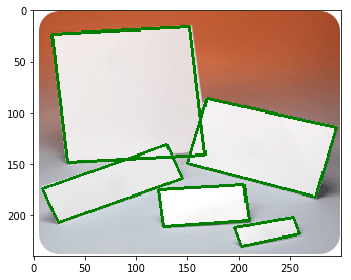

In [7]:
_, threshold = cv2.threshold(gray, 220, 230, cv2.THRESH_TOZERO)
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    contour = Contour(cnt)
    approx = contour.approx

    if len(approx) >= 4 and contour.area < 50000 and contour.area > 20:
        splited = contour.split_contours()
        for i in range(len(splited)):
            if len(splited[i]) >= 4:
                cont = np.vstack((splited[i]))
                cv2.drawContours(image, [cont], 0, (0, 127, 0), 2)
            if len(splited[i]) == 3:
                res = contour.make_rectangle(splited[i])
                cv2.drawContours(image, [res], 0, (0, 127, 0), 2)


    x = approx.ravel()[0]
    y = approx.ravel()[1]

imshow(image)
show()